# Geospatial Machine Learning: Classifying Land Use Based on Environmental and Economic Features

# 1. Introduction

In this project, we analyze the Geospatial Environmental and Socioeconomic Data to explore the relationship between tree cover loss by dominant driver, land cover, and Gross Domestic Product (GDP) across different Philippine regions. Our goal is to extract insights by examining how economic activity and land use patterns relate to deforestation and environmental change. By integrating spatial layers such as land cover classification, tree cover loss drivers, and gridded GDP data, we aim to identify regional trends and potential correlations that reveal the socioeconomic and environmental dynamics influencing forest degradation.

Specifically, we seek to answer the question:
How does tree cover loss by its dominant drivers correlate with land cover types and regional economic activity (GDP), and what patterns emerge across Luzon, Visayas, and Mindanao?

# 2. Description of the Dataset

## Geospatial Environmental and Socioeconomic Data  
**by Cathetorres (2020) – Kaggle**

This dataset is a comprehensive compilation of global **geospatial vector and raster data**, integrating diverse environmental and socioeconomic indicators. Collected from multiple authoritative sources, it provides detailed spatial layers useful for analysis in sustainability, development, and environmental monitoring.

The dataset is structured into **12 thematic folders**, each covering a distinct data category:

1. **Cities and Towns** – Geospatial data for urban areas in point and polygon formats.  
2. **Roads and Railroads** – Global transportation infrastructure networks.  
3. **Airports and Ports** – Locations of major air and sea transportation hubs.  
4. **Power Plants** – Spatial distribution of energy production facilities.  
5. **Gridded Population (2015)** – High-resolution (250 m) global population estimates.  
6. **Gridded GDP and HDI (1990–2015)** – Socioeconomic data showing economic productivity and development trends over time.  
7. **Land Cover (2015)** – Classification of global land cover types based on satellite data.  
8. **Tree Cover Loss by Dominant Driver** – Causes of deforestation disaggregated by primary driving factors.  
9. **Carbon Accumulation Potential** – Estimates of carbon sequestration from natural forest regrowth in forests and savannas.  
10. **Solar Energy Potential** – Spatial potential for solar power generation across the globe.  
11. **Air Temperature** – Global surface temperature data for climate studies.  
12. **Global Cattle Distribution (2010)** – Spatial density of cattle populations with 5-arcminute resolution.

## Dataset Folders Used

For this project, we utilize selected folders from the **Geospatial Environmental and Socioeconomic Data** collection to analyze the relationship between **tree cover loss**, **land cover**, and **economic activity (GDP)** in the Philippines. Our analysis focuses on understanding how different land use patterns and levels of economic development may be associated with forest degradation and environmental change.

### Land Cover

- **7. Gridded Land Cover 2015**  
  This dataset provides a global classification of land cover types at a 250 m resolution. It includes categories such as forest, cropland, urban area, grassland, and water. We use this as a base layer to contextualize areas of tree cover loss and to examine how land cover varies across economic regions.

### Tree Cover Loss

- **8. Tree Cover Loss by Dominant Driver (2001–2019)**  
  This dataset identifies the **main driver of tree cover loss** in each 10 km grid cell, classified into categories such as commodity-driven deforestation, shifting agriculture, forestry, wildfire, and urbanization. It allows us to assess how and why forest loss occurs in different parts of the country.

### Economic Activity

- **6. Gridded Gross Domestic Product and Human Development Index (1990–2015)**  
  This dataset provides **total GDP (PPP)** values at a 5 arc-minute (~10 km) resolution, enabling us to estimate economic activity at subnational scales. We use the 2015 GDP layer to explore potential spatial correlations between economic development and tree cover loss patterns.


# 3. Importing Files and Python Libraries

Here are the libraries and modules that will be used in this notebook:

In [4]:
import rasterio
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rasterio.enums import Resampling
from rasterio.warp import reproject

### Importing the Files

Loads three geospatial datasets: tree cover loss, land cover, and GDP

In [5]:
tl_path = 'Goode_FinalClassification_19_05pcnt_prj.tif'
lc_path = 'ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7.tif'
gdp_path = 'GDP_PPP_1990_2015_5arcmin_v2.nc'

**Load Tree Cover Loss by Dominant Driver and Load Land Cover**

Loads tree cover loss and land cover rasters and extracts their metadata for further processing.

In [6]:
with rasterio.open(tl_path) as tree_src:
    tree_data = tree_src.read(1)
    tree_transform = tree_src.transform
    tree_crs = tree_src.crs
    tree_nodata = tree_src.nodata
    tree_meta = {
        'crs': tree_crs,
        'transform': tree_transform
    }
    print(f"Tree Cover Loss Raster: {tree_data.shape}, CRS: {tree_crs}")

with rasterio.open(lc_path) as lc_src:
    lc_data = lc_src.read(1)
    lc_transform = lc_src.transform
    lc_crs = lc_src.crs
    lc_nodata = lc_src.nodata
    lc_meta = {
        'crs': lc_crs,
        'transform': lc_transform
    }
    print(f"Land Cover Raster: {lc_data.shape}, CRS: {lc_crs}")

Tree Cover Loss Raster: (1864, 3737), CRS: EPSG:4326
Land Cover Raster: (64800, 129600), CRS: EPSG:4326


**Load GDP**

Loads and extracts 2015 GDP data from the NetCDF file using xarray.

In [7]:
ds = xr.open_dataset(gdp_path)
print(ds)

# Extract 2015 GDP layer
gdp_2015 = ds['GDP_PPP'].sel(time=2015)
print(f"GDP 2015 shape: {gdp_2015.shape}")

<xarray.Dataset> Size: 970MB
Dimensions:    (longitude: 4320, latitude: 2160, time: 26)
Coordinates:
  * longitude  (longitude) float32 17kB -180.0 -179.9 -179.8 ... 179.9 180.0
  * latitude   (latitude) float32 9kB 89.96 89.88 89.79 ... -89.79 -89.88 -89.96
  * time       (time) float32 104B 1.99e+03 1.991e+03 ... 2.014e+03 2.015e+03
Data variables:
    GDP_PPP    (time, latitude, longitude) float32 970MB ...
Attributes:
    creation_date:     02-Aug-2017 14:30:34
    resolution:        5 arc-min
    projection:        WGS84
    extent:            lat: 90�S - 90�N; lon: 180�E - 180�W
    product:           Total Gross Domestic Production (GDP) (PPP) for years ...
    citation:          When using the data, please refer to following publica...
    more information:  For more information, see: TBA
GDP 2015 shape: (2160, 4320)


# 4. Data Preprocessing and Cleaning

Before conducting analysis, the geospatial datasets require preprocessing to ensure they are properly aligned and comparable. We reproject and resample the datasets. Additionally, we address missing or invalid data by filtering out NoData values and outliers.

**Checking the Resolution**

In [8]:
print(f"Tree Loss CRS: {tree_crs}, Res: {tree_transform[0]}°")
print(f"Land Cover CRS: {lc_crs}, Res: {lc_transform[0]}°")
print(f"GDP CRS: EPSG:4326 (assumed), Res: ~5 arcmin (~10 km)")

Tree Loss CRS: EPSG:4326, Res: 0.09634259943603331°
Land Cover CRS: EPSG:4326, Res: 0.002777777777778°
GDP CRS: EPSG:4326 (assumed), Res: ~5 arcmin (~10 km)


**Resampling**

Since the shape of the datasets are not alligned we will define the spatial transform and shape of the 2015 GDP grid for alignment with other datasets.

In [9]:
gdp_lon = gdp_2015['longitude'].values
gdp_lat = gdp_2015['latitude'].values

from rasterio.transform import from_origin
gdp_transform = from_origin(
    west=gdp_lon.min(),
    north=gdp_lat.max(),
    xsize=abs(gdp_lon[1] - gdp_lon[0]),
    ysize=abs(gdp_lat[1] - gdp_lat[0])
)

gdp_shape = gdp_2015.shape

Reprojects a source raster array to match a target shape, transform, and CRS.

In [10]:
def reproject_match(src_array, src_meta, dst_shape, dst_transform, dst_crs="EPSG:4326", method=Resampling.mode):
    dst_array = np.empty(dst_shape, dtype=src_array.dtype)
    reproject(
        source=src_array,
        destination=dst_array,
        src_transform=src_meta['transform'],
        src_crs=src_meta['crs'],
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=method
    )
    return dst_array

In [11]:
tree_data_resampled = reproject_match(
    src_array=tree_data,
    src_meta=tree_meta,
    dst_shape=gdp_shape,
    dst_transform=gdp_transform,
    method=Resampling.nearest
)

lc_data_resampled = reproject_match(
    src_array=lc_data,
    src_meta=lc_meta,
    dst_shape=gdp_shape,
    dst_transform=gdp_transform,
    method=Resampling.mode
)

**Mask Invalid Values and Create DataFrame**

Filters valid pixels and creates a DataFrame combining GDP, tree loss driver, and land cover values.

In [12]:
gdp_array = gdp_2015.values

valid_mask = (
    (gdp_array >= 0) &
    (tree_data_resampled >= 0) & (tree_data_resampled <= 5) &
    (lc_data_resampled >= 0)
)

df = pd.DataFrame({
    "GDP": gdp_array[valid_mask],
    "TreeLossDriver": tree_data_resampled[valid_mask].astype(int),
    "LandCover": lc_data_resampled[valid_mask].astype(int)
})

In [13]:
print(df.head())

   GDP  TreeLossDriver  LandCover
0  0.0               0        200
1  0.0               0        200
2  0.0               0        200
3  0.0               0        200
4  0.0               0        200


**Creating a Dataframe**

Creates 2D latitude and longitude grids matching the GDP data shape using meshgrid.

In [14]:
lon_vals = gdp_2015['longitude'].values
lat_vals = gdp_2015['latitude'].values
lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)

Creates a DataFrame with GDP, tree loss driver, land cover, and coordinates for valid pixels.

In [15]:
df = pd.DataFrame({
    "GDP": gdp_array[valid_mask],
    "TreeLossDriver": tree_data_resampled[valid_mask].astype(int),
    "LandCover": lc_data_resampled[valid_mask].astype(int),
    "Lat": lat_grid[valid_mask],
    "Lon": lon_grid[valid_mask]
})

**Filtering**

Since our target location is only Philippines and its 3 main islands groups, we will filter the data based on the coordinates and store them in their own dataframes for easier access.

In [16]:
philippines_df = df[
    (df["Lat"] >= 4.5) & (df["Lat"] <= 21) &
    (df["Lon"] >= 116) & (df["Lon"] <= 127)
]

In [17]:
luzon_df = philippines_df[
    (philippines_df["Lat"] >= 12.0) & (philippines_df["Lat"] <= 21.0) &
    (philippines_df["Lon"] >= 118.0) & (philippines_df["Lon"] <= 124.0)
]

visayas_df = philippines_df[
    (philippines_df["Lat"] >= 9.5) & (philippines_df["Lat"] < 12.0) &
    (philippines_df["Lon"] >= 122.0) & (philippines_df["Lon"] <= 126.0)
]

mindanao_df = philippines_df[
    (philippines_df["Lat"] >= 4.5) & (philippines_df["Lat"] < 9.5) &
    (philippines_df["Lon"] >= 124.0) & (philippines_df["Lon"] <= 127.0)
]

# 5. Exploratory Data Analysis

In this section, we perform an exploratory analysis of the geospatial datasets,tree cover loss drivers, land cover, and Gross Domestic Product (GDP), to understand their spatial patterns and relationships across the Philippines. We focus on the three main island groups: Luzon, Visayas, and Mindanao, by filtering the data using approximate latitude and longitude boundaries.

It is important to note that these geographic filters define rectangular bounding boxes which approximate the locations of the Philippines and its island groups. Therefore, the resulting analyses are estimates, as this method does not account for the exact shapes or coastlines of the islands.

## 1. What is the distribution of Tree Cover Loss by Dominant Drivers in Philippines?

Tree Cover Loss Drivers in Philippines:
TreeLossDriver
0    1256
1    1153
2    2178
3     479
5     195
Name: count, dtype: int64 



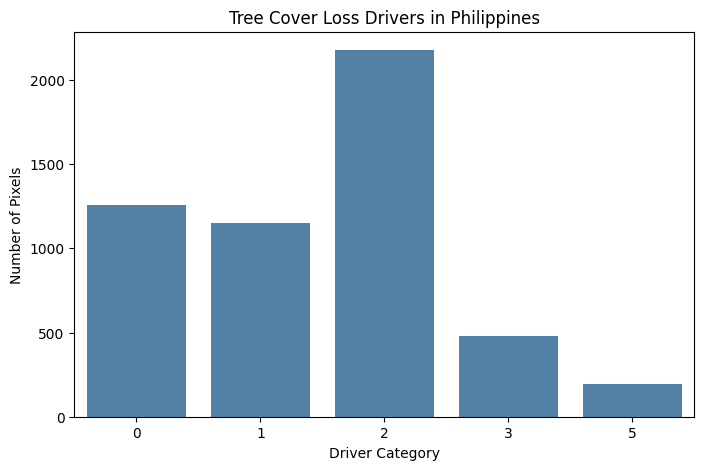

In [18]:
# Function to plot bar charts for a region with fixed color
def plot_driver_distribution(counts, region_name):
    plt.figure(figsize=(8,5))
    sns.barplot(x=counts.index.astype(str), y=counts.values, color='steelblue')
    plt.title(f'Tree Cover Loss Drivers in {region_name}')
    plt.xlabel('Driver Category')
    plt.ylabel('Number of Pixels')
    plt.xticks(rotation=0)
    plt.show()

# Calculate counts for Philippines and regions
philippines_counts = philippines_df['TreeLossDriver'].value_counts().sort_index()
luzon_counts = luzon_df['TreeLossDriver'].value_counts().sort_index()
visayas_counts = visayas_df['TreeLossDriver'].value_counts().sort_index()
mindanao_counts = mindanao_df['TreeLossDriver'].value_counts().sort_index()

# Print counts
print("Tree Cover Loss Drivers in Philippines:")
print(philippines_counts, "\n")

# Plot bar charts
plot_driver_distribution(philippines_counts, 'Philippines')


## 2. What is the distribution of Tree Cover Loss by Dominant Drivers in the 3 main island groups?

In [19]:
# Print counts
print("Tree Cover Loss Drivers in Luzon:")
print(luzon_counts, "\n")

print("Tree Cover Loss Drivers in Visayas:")
print(visayas_counts, "\n")

print("Tree Cover Loss Drivers in Mindanao:")
print(mindanao_counts, "\n")

Tree Cover Loss Drivers in Luzon:
TreeLossDriver
0    549
1    134
2    892
3    147
5     98
Name: count, dtype: int64 

Tree Cover Loss Drivers in Visayas:
TreeLossDriver
0    247
1     20
2    361
3    104
5     42
Name: count, dtype: int64 

Tree Cover Loss Drivers in Mindanao:
TreeLossDriver
0    111
1    197
2    476
3    168
5     38
Name: count, dtype: int64 



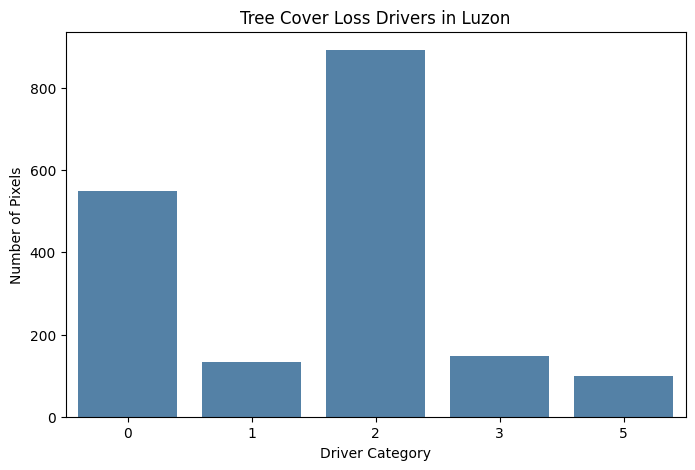

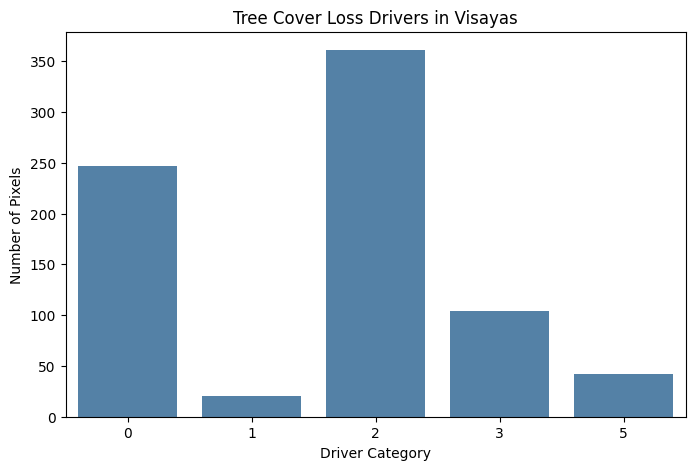

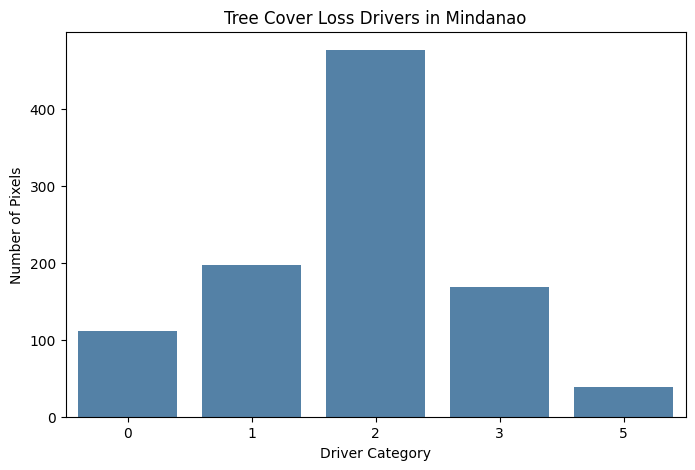

In [20]:
# Plot bar charts
plot_driver_distribution(luzon_counts, 'Luzon')
plot_driver_distribution(visayas_counts, 'Visayas')
plot_driver_distribution(mindanao_counts, 'Mindanao')

## 3. What is the distribution of Land Cover types in the Philippines and each island group?

In [21]:
def plot_landcover_distribution(counts, region_name):
    plt.figure(figsize=(8,5))
    sns.barplot(x=counts.index.astype(str), y=counts.values, color='forestgreen')
    plt.title(f'Land Cover Types in {region_name}')
    plt.xlabel('Land Cover Category')
    plt.ylabel('Number of Pixels')
    plt.xticks(rotation=0)
    plt.show()

In [22]:
philippines_lc_counts = philippines_df['LandCover'].value_counts().sort_index()
luzon_lc_counts = luzon_df['LandCover'].value_counts().sort_index()
visayas_lc_counts = visayas_df['LandCover'].value_counts().sort_index()
mindanao_lc_counts = mindanao_df['LandCover'].value_counts().sort_index()

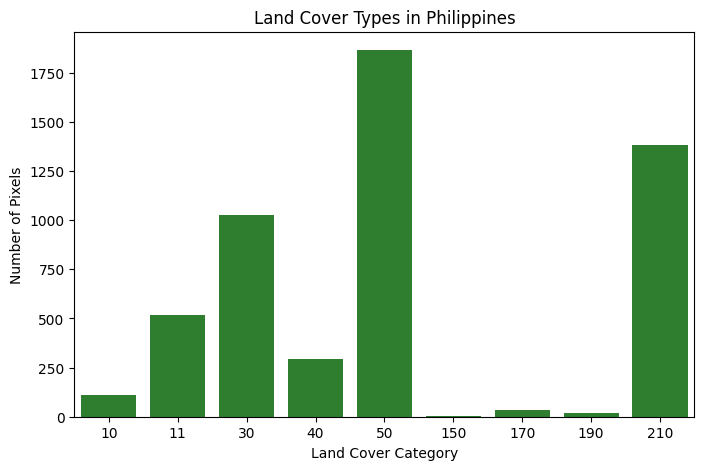

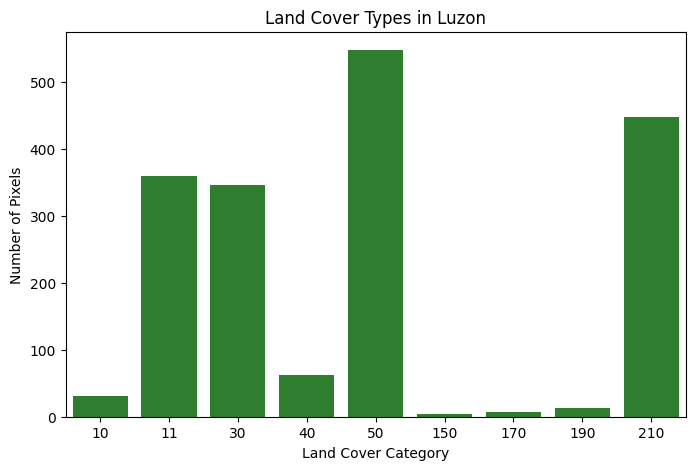

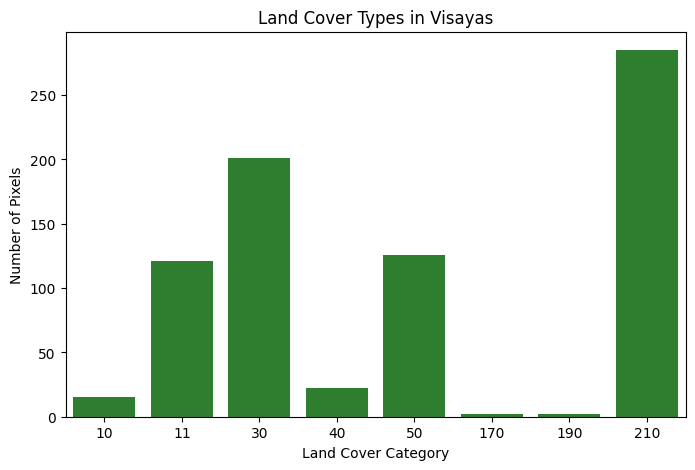

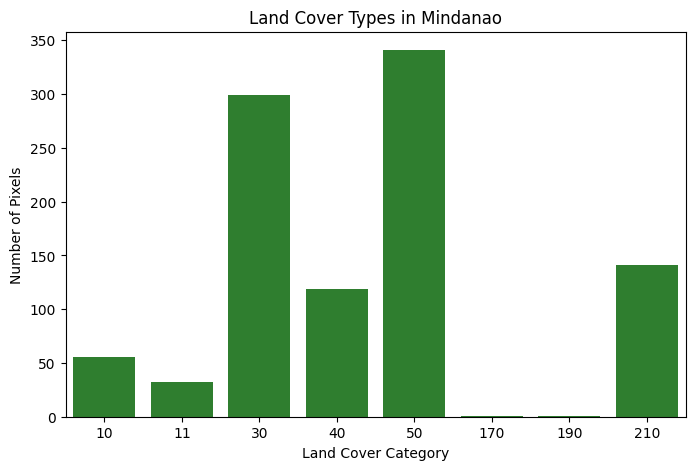

In [23]:
plot_landcover_distribution(philippines_lc_counts, 'Philippines')
plot_landcover_distribution(luzon_lc_counts, 'Luzon')
plot_landcover_distribution(visayas_lc_counts, 'Visayas')
plot_landcover_distribution(mindanao_lc_counts, 'Mindanao')

## 4. What is the GDP distribution in the Philippines and each island group?

In [25]:
def plot_gdp_distribution(df, region_name):
    plt.figure(figsize=(8,5))
    sns.histplot(df['GDP'], bins=30, color='gold', kde=True)
    plt.title(f'GDP Distribution in {region_name}')
    plt.xlabel('GDP (PPP)')
    plt.ylabel('Number of Pixels')
    plt.show()

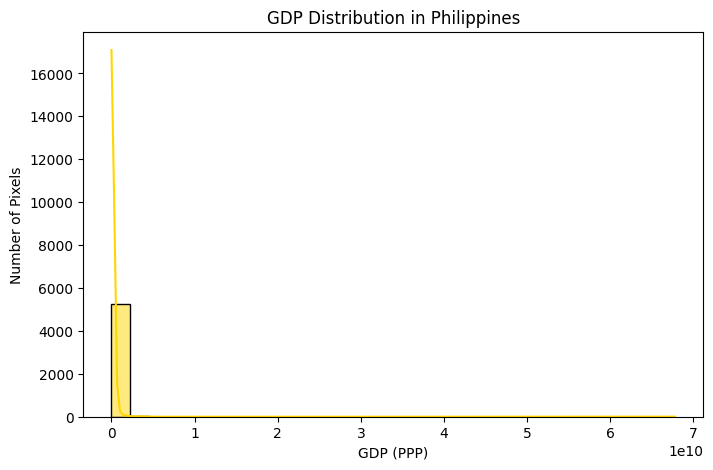

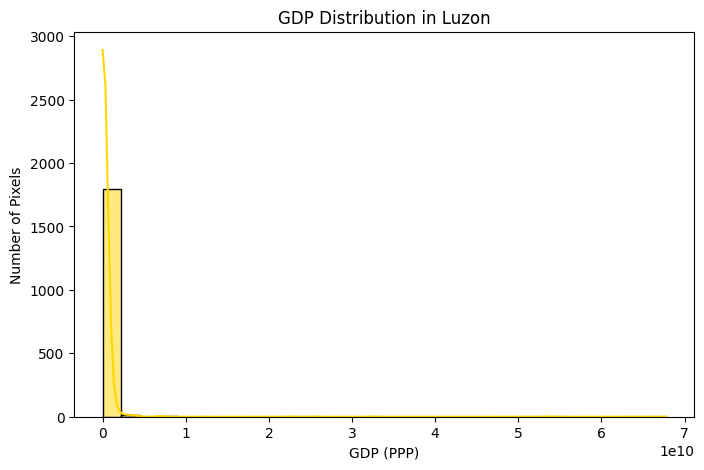

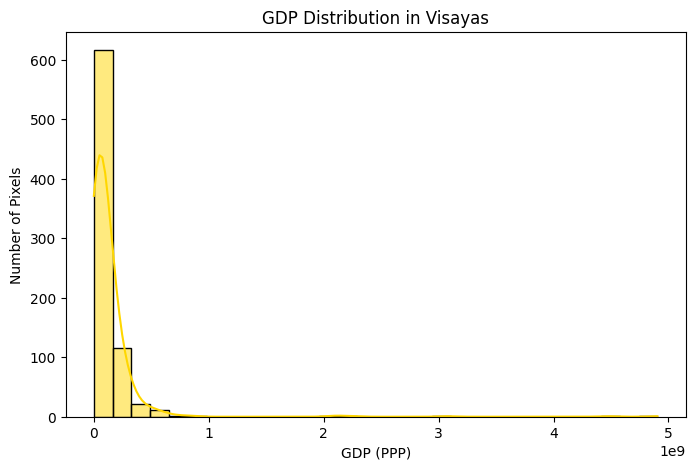

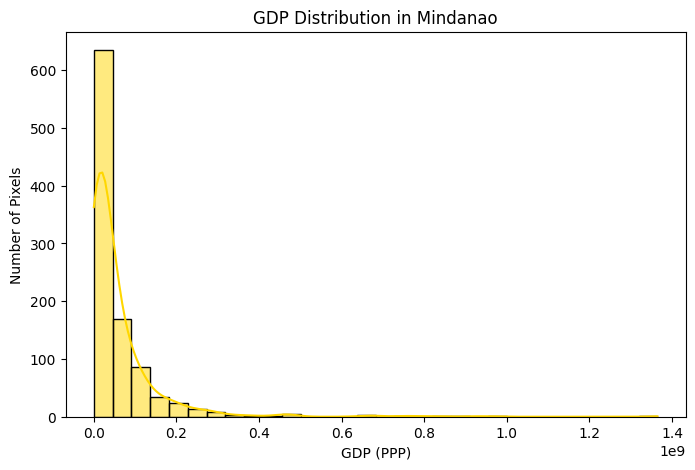

In [26]:
plot_gdp_distribution(philippines_df, 'Philippines')
plot_gdp_distribution(luzon_df, 'Luzon')
plot_gdp_distribution(visayas_df, 'Visayas')
plot_gdp_distribution(mindanao_df, 'Mindanao')

## 5. Is there a difference in land cover types across Luzon, Visayas, and Mindanao?

In [27]:
lc_luzon = luzon_df['LandCover'].value_counts().sort_index()
lc_visayas = visayas_df['LandCover'].value_counts().sort_index()
lc_mindanao = mindanao_df['LandCover'].value_counts().sort_index()


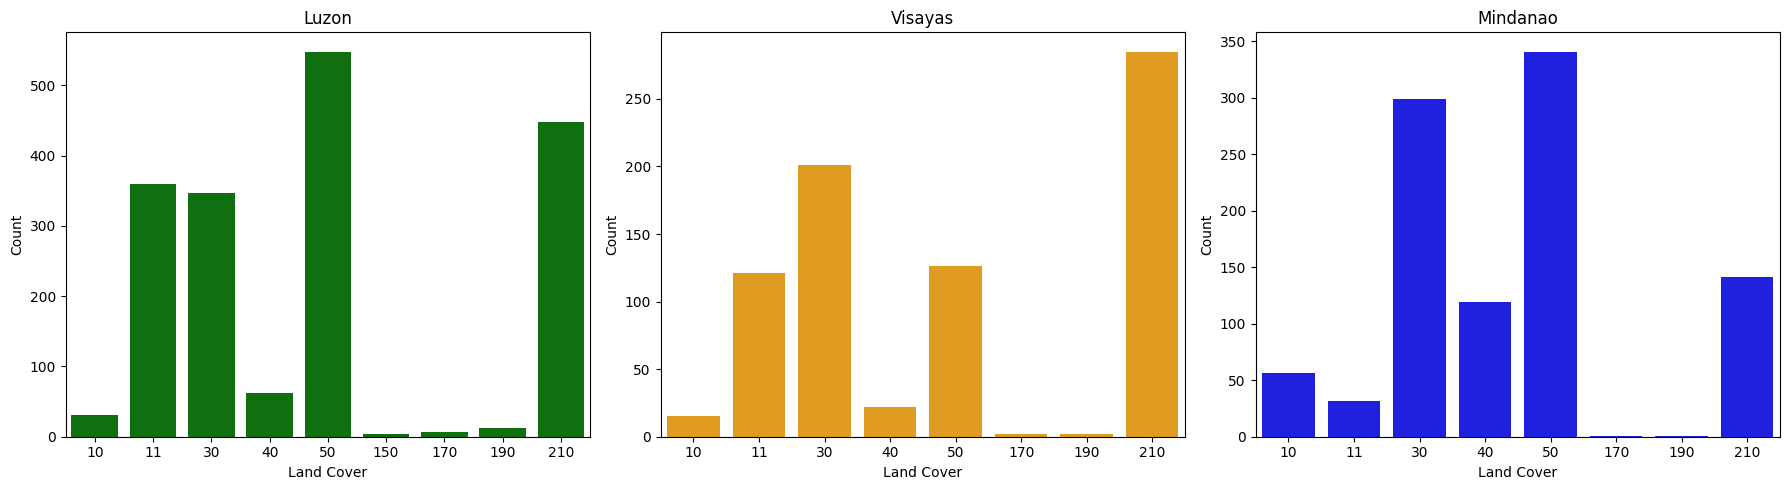

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.barplot(x=lc_luzon.index, y=lc_luzon.values, ax=axes[0], color='green')
axes[0].set_title("Luzon")
sns.barplot(x=lc_visayas.index, y=lc_visayas.values, ax=axes[1], color='orange')
axes[1].set_title("Visayas")
sns.barplot(x=lc_mindanao.index, y=lc_mindanao.values, ax=axes[2], color='blue')
axes[2].set_title("Mindanao")
for ax in axes: ax.set_xlabel("Land Cover"), ax.set_ylabel("Count")
plt.tight_layout()
plt.show()


## 6. What is the correlation between GDP, Land Cover, and Tree Loss Driver in Luzon

In [29]:
corr_luzon = luzon_df[["GDP", "TreeLossDriver", "LandCover"]].corr()
corr_luzon

,GDP,TreeLossDriver,LandCover
GDP,1.000000,-0.005683,0.063359
TreeLossDriver,-0.005683,1.000000,-0.210901
LandCover,0.063359,-0.210901,1.000000


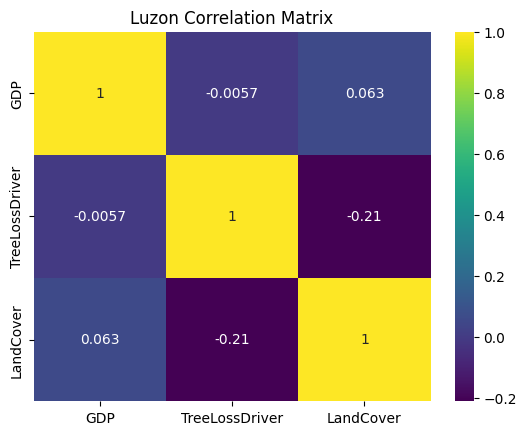

In [30]:
sns.heatmap(corr_luzon, annot=True, cmap="viridis")
plt.title("Luzon Correlation Matrix")
plt.show()


## 7. Is there spatial clustering of low-GDP areas in Mindanao?

In [40]:
low_gdp_threshold = mindanao_df["GDP"].quantile(0.25)
low_gdp_mindanao = mindanao_df[mindanao_df["GDP"] <= low_gdp_threshold]

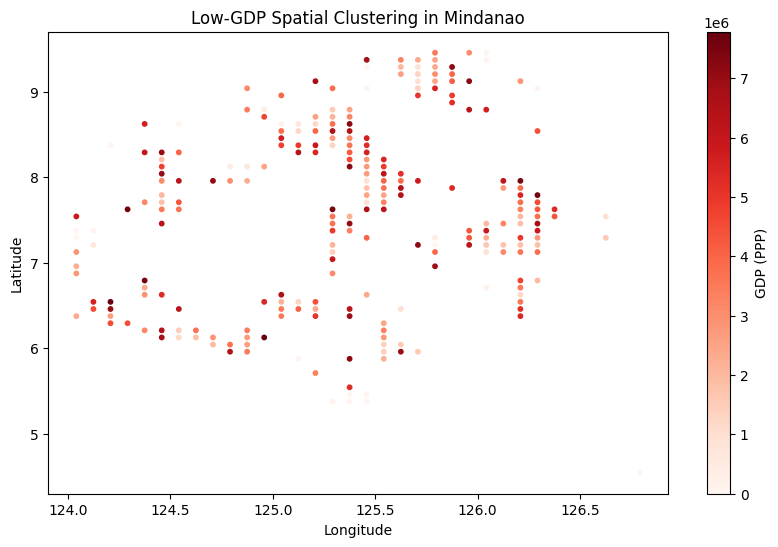

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(low_gdp_mindanao["Lon"], low_gdp_mindanao["Lat"], c=low_gdp_mindanao["GDP"], cmap="Reds", s=10)
plt.colorbar(label="GDP (PPP)")
plt.title("Low-GDP Spatial Clustering in Mindanao")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


## 8. What is the distribution of tree loss drivers across major land cover types (e.g., forest, cropland, urban)?

In [64]:
cross_tab = philippines_df.groupby(['LandCover', 'TreeLossDriver']).size().unstack(fill_value=0)

In [65]:
cross_tab_norm = cross_tab.div(cross_tab.sum(axis=1), axis=0)

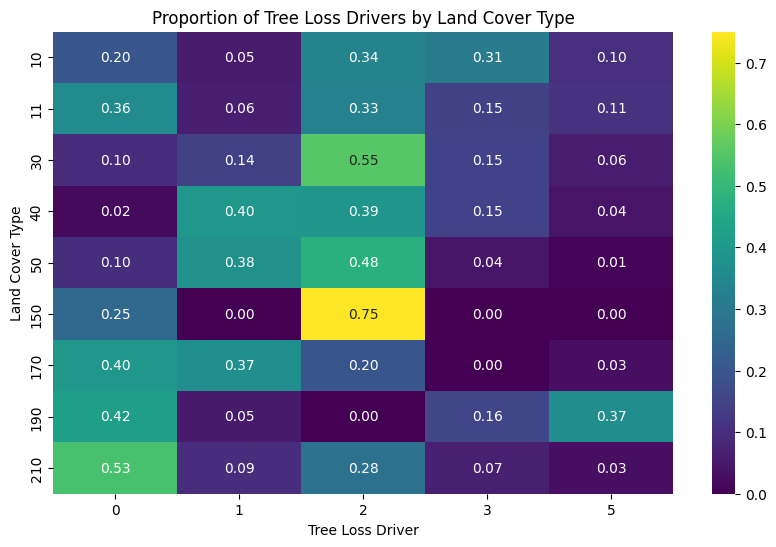

In [66]:
plt.figure(figsize=(10,6))
sns.heatmap(cross_tab_norm, cmap='viridis', annot=True, fmt=".2f")
plt.title('Proportion of Tree Loss Drivers by Land Cover Type')
plt.xlabel('Tree Loss Driver')
plt.ylabel('Land Cover Type')
plt.show()

## 9. What is the relationship between tree loss intensity and economic output in Luzon?

In [43]:
driver_gdp_luzon = luzon_df.groupby("TreeLossDriver")["GDP"].mean().sort_index()
driver_gdp_luzon

TreeLossDriver
0    5.391229e+08
1    3.808576e+07
2    6.526911e+07
3    1.664572e+08
5    1.112467e+09
Name: GDP, dtype: float32

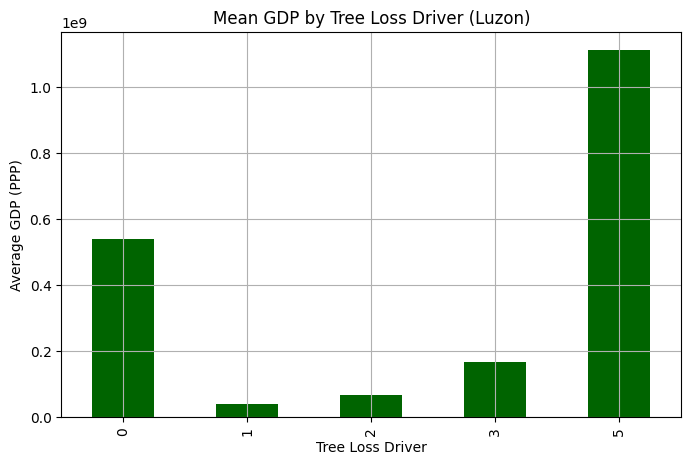

In [44]:
driver_gdp_luzon.plot(kind="bar", figsize=(8,5), color='darkgreen')
plt.title("Mean GDP by Tree Loss Driver (Luzon)")
plt.xlabel("Tree Loss Driver")
plt.ylabel("Average GDP (PPP)")
plt.grid(True)
plt.show()


## 10. How does land cover relate to GDP across Luzon, Visayas, and Mindanao?

In [52]:
full_df = pd.concat([luzon_df, visayas_df, mindanao_df], ignore_index=True)

In [62]:
gdp_by_lc = full_df.groupby(["Region", "LandCover"])["GDP"].mean().reset_index()
display(gdp_by_lc)
#gdp_by_lc.head(25)

,Region,LandCover,GDP
0,Luzon,10,3.208764e+08
1,Luzon,11,3.444161e+08
2,Luzon,30,1.284961e+08
3,Luzon,40,1.273607e+08
4,Luzon,50,3.330338e+07
5,Luzon,150,1.882860e+07
6,Luzon,170,6.010223e+08
7,Luzon,190,1.706700e+10
8,Luzon,210,1.383211e+08
9,Mindanao,10,1.534192e+08


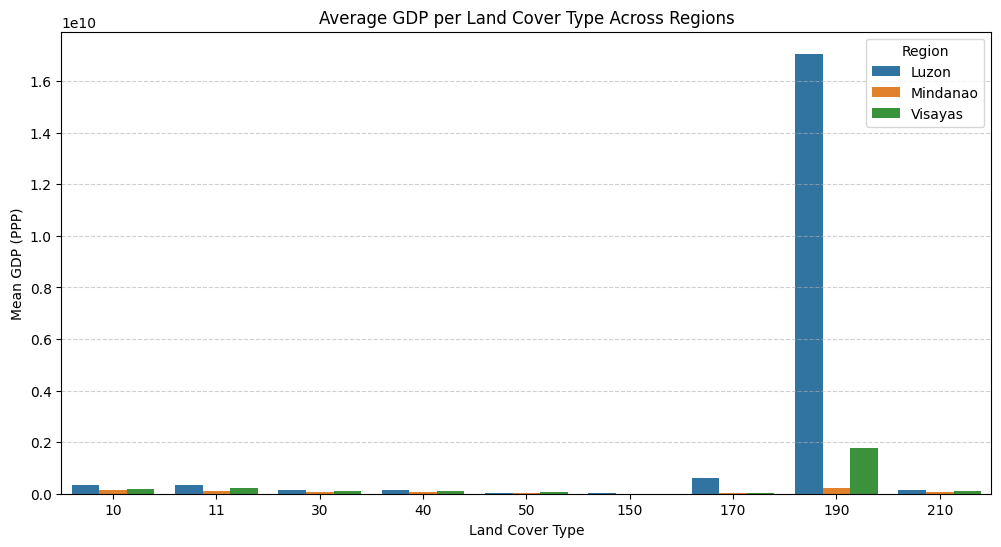

In [63]:
plt.figure(figsize=(12, 6))
sns.barplot(data=gdp_by_lc, x="LandCover", y="GDP", hue="Region")
plt.title("Average GDP per Land Cover Type Across Regions")
plt.xlabel("Land Cover Type")
plt.ylabel("Mean GDP (PPP)")
plt.legend(title="Region")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()


# Insights and Conclusion

# References